In [1]:
import SimpleITK as sitk
import os
import pandas as pd
import numpy as np
import time
import sys
import pydicom
import shutil
%matplotlib inline
import matplotlib.pyplot as plt
import ast

In [2]:
paths = [['temp/dicoms/in', 'temp/dicoms/out', 'temp/dicoms/fat', 'temp/dicoms/water'], 
         ['temp/dicoms/b50', 'temp/dicoms/b600', 'temp/dicoms/b900', 'temp/dicoms/adc']]
series_numbers = [[1, 2, 3, 4], [5, 6, 7, 8]]
series_descriptions=  [['in', 'out', 'fat', 'water'], ['b50', 'b600', 'b900', 'adc']]
group_descriptions = ['dixon', 'diffusion']


In [25]:
def load_sitk_image_volumes(paths, series_descriptions):
    imgs = []
    readers = []
    print('--- Loading Image Volumes in SimpleITK ---')
    for g, group in enumerate(paths):
        imgs.append([])
        readers.append([])
        for i, path in enumerate(group):
            for dirName, subdirList, fileList in os.walk(path):
                verbose_path = list(set([dirName for filename in fileList if filename.lower().endswith('.dcm')]))
                if len(verbose_path):  # this code is pretty gross but it works
                    print('"' + series_descriptions[g][i] + '"', 'image volume loaded')
                    reader = sitk.ImageSeriesReader()
                    dcm_names = reader.GetGDCMSeriesFileNames(verbose_path[0])
                    reader.SetFileNames(dcm_names)
                    reader.MetaDataDictionaryArrayUpdateOn()
                    reader.LoadPrivateTagsOn()
                    imgs[g].append(reader.Execute())
                    readers[g].append(reader)
    return imgs, readers

In [26]:
imgs, readers = load_sitk_image_volumes(paths, series_descriptions)

--- Loading Image Volumes in SimpleITK ---
"in" image volume loaded
"out" image volume loaded
"fat" image volume loaded
"water" image volume loaded
"b50" image volume loaded
"b600" image volume loaded
"b900" image volume loaded
"adc" image volume loaded


In [9]:
def myshow2(imgs, titles):
    n_col = max([len(group) for group in imgs])
    n_row = len(imgs)
    fig, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
    fig.set_dpi(100)
    # fig.set_size_inches(20,6)
    for g, group in enumerate(imgs):
        i = 0
        for img, ax in (zip(group, axs[g])):
            spacing = img.GetSpacing()
            x_space = spacing[0]
            z_space = spacing[2]
            y = int(img.GetHeight()/1.7)
            nda_y = sitk.GetArrayViewFromImage(img)[:,y,:]
            x_size = nda_y.shape[1]
            z_size = nda_y.shape[0]
            extent = (0, x_size*x_space, z_size*z_space, 0)
            ax.set_title(titles[g][i])
            t = ax.imshow(nda_y,extent=extent,interpolation=None, origin='lower', 
                  cmap='Greys_r', vmin=nda_y.min(), vmax=nda_y.max()/2)
            i += 1
    fig.savefig("scans.pdf", bbox_inches='tight')
    for ax in axs.flatten():
        if not ax.images:
            ax.axis('off')

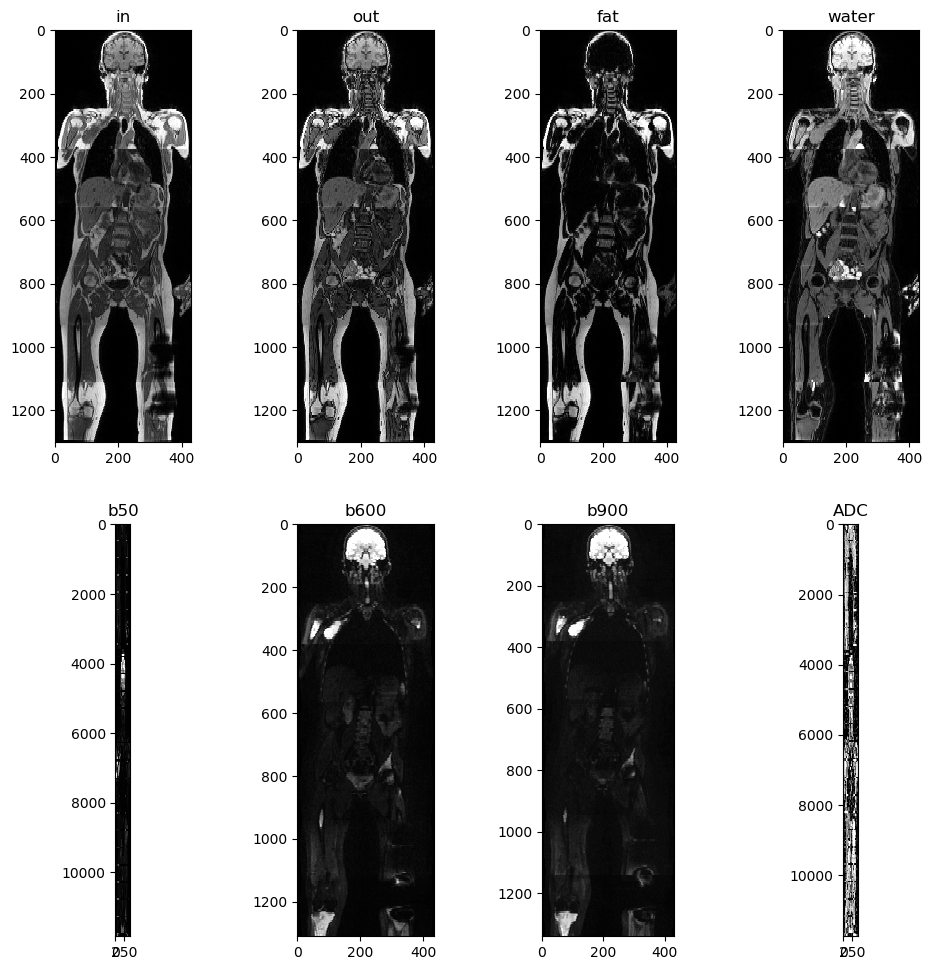

In [20]:
myshow2(imgs, series_descriptons)

In [10]:
def match_fovs_2(image_volumes, series_descriptons):
    imgs = [img for group in image_volumes for img in group]  # flattens nested list
    origin = tuple(np.max([img.GetOrigin()[i] for img in imgs]) for i in range(3))
    fov = tuple(np.min([img.GetSize()[i]*img.GetSpacing()[i] for img in imgs]) for i in range(3))
    directions = [img.GetDirection() for img in imgs]
    direction = max(set(directions), key = directions.count)

    imgs_new = []

    for g, group in enumerate(image_volumes):
        spacings = [img.GetSpacing() for img in group]
        ref_spacing = max(set(spacings), key = spacings.count)

        ref_size = tuple(int(round(fov/spacing, 0)) for fov, spacing in zip(fov, ref_spacing))

        resample = sitk.ResampleImageFilter()
        resample.SetOutputSpacing(ref_spacing)
        resample.SetSize(ref_size)
        resample.SetOutputDirection(direction)
        resample.SetOutputOrigin(origin)
        resample.SetTransform(sitk.Transform())
        resample.SetDefaultPixelValue(3)
        resample.SetInterpolator(sitk.sitkLinear)
        
        print('Resampling Image Volumes:')
        imgs_new.append([resample.Execute(img) for img in group])
        
        for i, img in enumerate(group):
            print('-------',series_descriptons[g][i],'-------')
            print('Origin:', img.GetOrigin(), '---->', origin)
            print('Direction:', img.GetDirection(), '---->', direction)
            print('Spacing:', img.GetSpacing(), '---->', ref_spacing)
            print('FOV:', tuple(sp*si for sp, si in zip(img.GetSpacing(), img.GetSize())), 
                  '---->', fov)
            print('Size:', img.GetSize(), '---->', ref_size)
            
    return imgs_new

In [24]:
imgs_new_2 = match_fovs_2(imgs, series_descriptions)

Resampling Image Volumes:
------- in -------
Origin: (-218.72946166992188, -163.67332458496094, -1102.43017578125) ----> (-218.72946166992188, -163.67332458496094, -1102.43017578125)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) ----> (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Spacing: (0.8398, 0.8398, 5.0) ----> (0.8398, 0.8398, 5.0)
FOV: (429.9776, 322.4832, 1300.0) ----> (429.9776, 322.4832, 1300.0)
Size: (512, 384, 260) ----> (512, 384, 260)
------- out -------
Origin: (-218.72946166992188, -163.67332458496094, -1102.43017578125) ----> (-218.72946166992188, -163.67332458496094, -1102.43017578125)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) ----> (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Spacing: (0.8398, 0.8398, 5.0) ----> (0.8398, 0.8398, 5.0)
FOV: (429.9776, 322.4832, 1300.0) ----> (429.9776, 322.4832, 1300.0)
Size: (512, 384, 260) ----> (512, 384, 260)
------- fat -------
Origin: (-218.72946166992188, -163.67332458496094, -1102.43017578125) ----> (

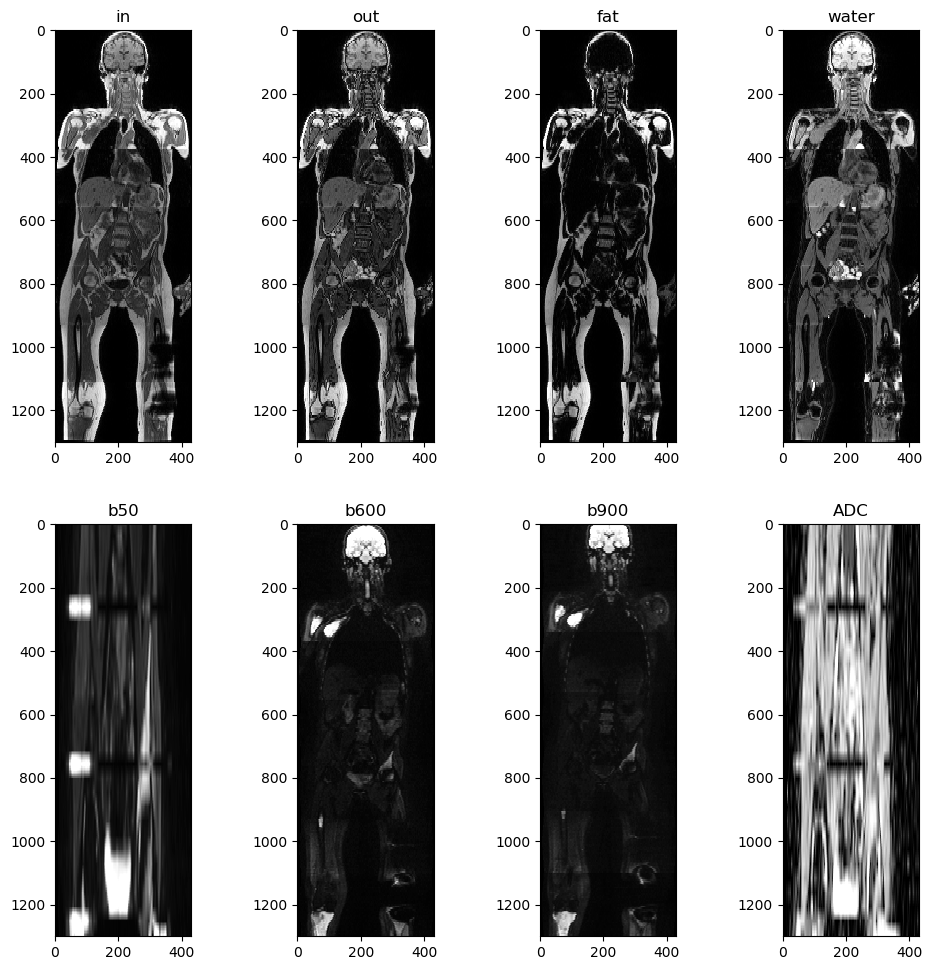

In [25]:
myshow2(imgs_new_2, series_descriptons)

create slice spacing (diff) column and delete duplicate slices

In [451]:
len(df[df['diff_up'] == 0]) == len(df[df['diff_down'] == 0]) == 0

True

In [453]:
st = 5

In [525]:
len(d)

260

basicaly anything using indexing use df.loc[idx] and anything applied to the whole sub-dataframe just use d

diff is only useful to find the edges of the largest group, to continually resample slices which don't fit on the same grid you need to keep a track of slice position and add 5 each time.

How about you create a list of slice positions that increase by st each time and then as the index increases it selects the next one, and you find the closest two slices to be s_prev and s_next. range of this list goes until last slice location or less. and in the case of the upwards direction first slice or more. 

could insert new slices based on reference slice locations. Then sort df and and iterate through calculating slices where pixel_array = None. But that would still require something to keep track of which slices are interpolated and which are "original" oorrrr
put the new slices in a new dataframe and then add the rest later
although that is the same as putting them at the end
iterate through the list of new reference slices and find the two closest slices with:
df.ix[(df['num']-input).abs().argsort()[:2]] 

In [3]:
    def correct_slice_order(df):
        print('-- Checking DICOM slice order --')
        df.sort_values(by=['Sequence', 'Series', 'SliceLocation'], ascending=False, inplace=True)
        for idx, df_select in df.groupby(['Sequence', 'Series']):  # level = [0,1] == ['Sequence','Series']
            if df_select['InstanceNumber'].is_monotonic:
                print(idx, 'Slice order correct')
            else:
                print('Correcting', idx, 'slice order')
            df.loc[idx, 'InstanceNumber'] = range(1, len(df_select) + 1)
            ## This has moved since the slice correction creates 2,4,6 which is monotonic, but not
            # correct.....

        df.reset_index(inplace=True)
        df.drop('Slice', axis=1, inplace=True)
        df.set_index(['Sequence', 'Series', 'InstanceNumber'], drop=False, inplace=True)
        df.drop(['Sequence', 'Series'], axis=1, inplace=True)
        df.rename_axis(index={'InstanceNumber': 'Slice'}, inplace=True)
        df.sort_index(inplace=True)  # Basica
        return df

This method of using np arrays is much quicker...

In [4]:
df = pd.read_csv('df.csv')
df.drop('Slice', axis=1, inplace=True)  # for some reason df has a slice column, check in real code
df.set_index(['Sequence', 'Series', 'InstanceNumber'], drop=False, inplace=True)
df.drop(['Sequence', 'Series'], axis=1, inplace=True)  # Keep InstanceNumber column
df.rename_axis(index={'InstanceNumber': 'Slice'}, inplace=True)

st = 5

for idx, df_select in df.groupby(['Sequence', 'Series']):
    df.loc[idx, 'diff_down'] = df_select['SliceLocation'].diff().abs().round(2)
    # df.loc[idx][df.loc[idx,'diff_down'] == 0]['Path'].apply(lambda x: os.remove(x))  # remove duplicates
    print(idx, ' - Removed', len(df.loc[idx][df.loc[idx,'diff_down'] == 0]), 'duplicates')
df = df[df['diff_down'] != 0]  # drop duplicate rows

for idx, df_select in df.groupby(['Sequence', 'Series']):
    df.loc[idx, 'diff_up'] = df_select['SliceLocation'].diff(-1).abs().round(2)
    
#####################

for idx, d in df.groupby(['Sequence', 'Series']):
    print(idx, 'Loading Pixel Array Data')
    df.loc[idx, 'PixelArray'] = d.Path.apply(lambda x: pydicom.dcmread(x).pixel_array)
    if not all(diff == st for diff in df.loc[idx, 'diff_down']):
        # df.loc[idx, 'Path'] = None ??  # Remove path -- also delete dcms?
        # first non-contiguous slice at beginnging of largest contiguous group
        start = d[d['diff_up'] != st].dropna()['InstanceNumber'].diff(-1).idxmin()[2]
        # first non-contiguous slice at end of largest contiguous group
        end = d[d['diff_down'] != st].dropna()['InstanceNumber'].diff().idxmax()[2]
        for i in range(start+1, end):
            df.loc[idx + (i,), 'Contiguous'] = 'yes'
        # df.loc[idx + (range(start+1, end),), 'Contiguous'] = 'yes' -- NO IDEA WHY THIS DOESN"T WORK
        sl_ref_up = np.arange(df.loc[idx + (start+1,)].SliceLocation + st,
                             df.loc[idx, 'SliceLocation'].max(), st)  # new slice locations
        sl_ref_down = np.arange(df.loc[idx + (end-1,)].SliceLocation - st, 
                            df.loc[idx, 'SliceLocation'].min(), -st)  # new slice locations
        s_template = pd.DataFrame.copy(df.loc[idx+(1,)])
        shape = df.loc[idx + (1,), 'PixelArray'].shape
        s_template.PixelArray = np.ones(shape)*-1
        s_template.Path = 'no path'
        for i, sl in enumerate(np.concatenate((sl_ref_down, sl_ref_up))):
            s_new = pd.DataFrame.copy(s_template)
            s_new.SliceLocation = sl
            ipp_new = ast.literal_eval(s_new.ImagePositionPatient)
            ipp_new[2] = sl
            s_new.ImagePositionPatient = ipp_new
            s_new.Contiguous = 'yes'
            df.loc[idx+(i+len(d)+50,)] = s_new  
            # was having issues with slice overwriting so I just made the index gap big (50)
    elif all(diff == st for diff in df.loc[idx, 'diff_down']):
        df.loc[idx, 'Contiguous'] = 'yes'

df = correct_slice_order(df)                

('diffusion', 'adc')  - Removed 2 duplicates
('diffusion', 'b50')  - Removed 3 duplicates
('diffusion', 'b600')  - Removed 3 duplicates
('diffusion', 'b900')  - Removed 4 duplicates
('dixon', 'fat')  - Removed 0 duplicates
('dixon', 'in')  - Removed 0 duplicates
('dixon', 'out')  - Removed 0 duplicates
('dixon', 'water')  - Removed 0 duplicates
('diffusion', 'adc') Loading Pixel Array Data


//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2854: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


('diffusion', 'b50') Loading Pixel Array Data


//anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


('diffusion', 'b600') Loading Pixel Array Data
('diffusion', 'b900') Loading Pixel Array Data
('dixon', 'fat') Loading Pixel Array Data
('dixon', 'in') Loading Pixel Array Data
('dixon', 'out') Loading Pixel Array Data
('dixon', 'water') Loading Pixel Array Data
-- Checking DICOM slice order --
Correcting ('diffusion', 'adc') slice order
Correcting ('diffusion', 'b50') slice order
Correcting ('diffusion', 'b600') slice order
Correcting ('diffusion', 'b900') slice order
Correcting ('dixon', 'fat') slice order
Correcting ('dixon', 'in') slice order
Correcting ('dixon', 'out') slice order
Correcting ('dixon', 'water') slice order


//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2880: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
for idx, d in df.groupby(['Sequence', 'Series']):
    if not all(c == 'yes' for c in df.loc[idx, 'Contiguous']):
        print(idx, 'Interpolating new slices')
        shape = df.loc[idx + (1,), 'PixelArray'].shape
        for i in range(1,len(df.loc[idx])):
            if np.all(df.loc[idx+(i,), 'PixelArray'] == -1):
                i_prev = i-1
                i_next = i+1
                while np.all(df.loc[idx+(i_prev,), 'PixelArray'] == -1): i_prev -= 1
                while np.all(df.loc[idx+(i_next,), 'PixelArray'] == -1): i_next += 1
                # Slice Locations:
                sl_prev = df.loc[idx+(i_prev,), 'SliceLocation']
                sl = df.loc[idx+(i,), 'SliceLocation']
                sl_next = df.loc[idx+(i_next,), 'SliceLocation']
                # Pixel Arrays:
                pa_prev = df.loc[idx+(i_prev,), 'PixelArray'].reshape(shape)
                pa_next = df.loc[idx+(i_next,), 'PixelArray'].reshape(shape)
                # for some bizarre reason the calculated 2d array is 1d (flat) in the df
                x1 = abs(sl-sl_prev)
                x2 = abs(sl_next-sl)
                r1 = (x1/(x1+x2))
                r2 = (x2/(x1+x2))
                pa_new = r1*pa_prev + r2*pa_next
                df.loc[idx + (i,), 'PixelArray'] = pa_new

df = df[df['Contiguous'] == 'yes']
df = correct_slice_order(df)
df.dropna(subset = ['PixelArray'], inplace=True)  # this should not be required.... something wrong

('diffusion', 'adc') Interpolating new slices
('diffusion', 'b50') Interpolating new slices
('diffusion', 'b600') Interpolating new slices
('diffusion', 'b900') Interpolating new slices
('dixon', 'fat') Interpolating new slices
('dixon', 'in') Interpolating new slices
('dixon', 'out') Interpolating new slices
('dixon', 'water') Interpolating new slices
-- Checking DICOM slice order --
('diffusion', 'adc') Slice order correct
('diffusion', 'b50') Slice order correct
('diffusion', 'b600') Slice order correct
('diffusion', 'b900') Slice order correct
('dixon', 'fat') Slice order correct
('dixon', 'in') Slice order correct
('dixon', 'out') Slice order correct
('dixon', 'water') Slice order correct


In [8]:
imgs = []
readers = []
print('--- Loading Image Volumes in SimpleITK ---')
for g, group in enumerate(series_descriptions):
    imgs.append([])
    readers.append([])
    for s, series in enumerate(group):
        print('"' + series_descriptions[g][s] + '"', 'image volume loaded')
        shape = df.loc[group_descriptions[g], series, 1][['Rows','Columns']].to_list()
        shape = list(map(int, shape))
        volume = df.loc[group_descriptions[g], series]['PixelArray'].values
        volume = np.array([array.reshape(shape) for array in volume])
        volume = np.flip(volume,0)
        volume = volume.astype(np.int16)
        img = sitk.GetImageFromArray(volume)
        PixelSpacing = ast.literal_eval(df.loc[group_descriptions[g], series, 1]['PixelSpacing'])
        PixelSpacing.append(st)
        img.SetSpacing(PixelSpacing)
        try:
            Origin = ast.literal_eval(df.loc[group_descriptions[g], series].iloc[-1]['ImagePositionPatient'])
        except ValueError:
            Origin = df.loc[group_descriptions[g], series].iloc[-1]['ImagePositionPatient']
        img.SetOrigin(Origin)
        imgs[g].append(img)
        
        template_dcm_paths = list(df.loc[idx][df.loc[idx, 'Path'] != 'no path'].iloc[:2].Path)
        reader = sitk.ImageSeriesReader()
        reader.SetFileNames(list(template_dcm_paths))
        reader.MetaDataDictionaryArrayUpdateOn()
        reader.LoadPrivateTagsOn()
        _ = reader.Execute()
        readers[g].append(reader)
        
           
        

--- Loading Image Volumes in SimpleITK ---
"in" image volume loaded
"out" image volume loaded
"fat" image volume loaded
"water" image volume loaded
"b50" image volume loaded
"b600" image volume loaded
"b900" image volume loaded
"adc" image volume loaded


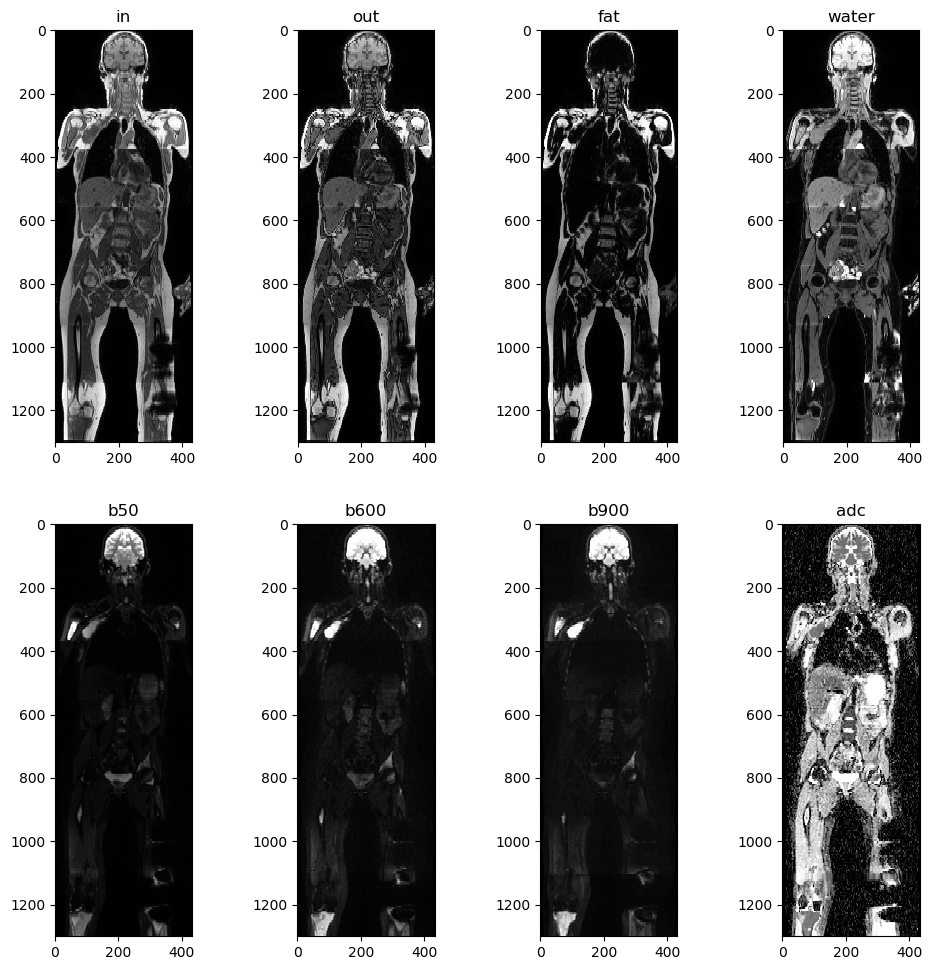

In [11]:
myshow2(imgs, series_descriptions)

In [12]:
imgs2 = match_fovs_2(imgs, series_descriptions)

Resampling Image Volumes:
------- in -------
Origin: (-218.72945685272, -163.67333027039, -1097.905877918) ----> (-218.72945685272, -163.67333027039, -1097.9058761596698)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) ----> (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Spacing: (0.8398, 0.8398, 5.0) ----> (0.8398, 0.8398, 5.0)
FOV: (429.9776, 322.4832, 1300.0) ----> (429.9776, 322.4832, 1300.0)
Size: (512, 384, 260) ----> (512, 384, 260)
------- out -------
Origin: (-218.72945685272, -163.67333027039, -1097.905877918) ----> (-218.72945685272, -163.67333027039, -1097.9058761596698)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0) ----> (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Spacing: (0.8398, 0.8398, 5.0) ----> (0.8398, 0.8398, 5.0)
FOV: (429.9776, 322.4832, 1300.0) ----> (429.9776, 322.4832, 1300.0)
Size: (512, 384, 260) ----> (512, 384, 260)
------- fat -------
Origin: (-218.72945685272, -163.67333027039, -1097.905877918) ----> (-218.72945685272, -163.673330270

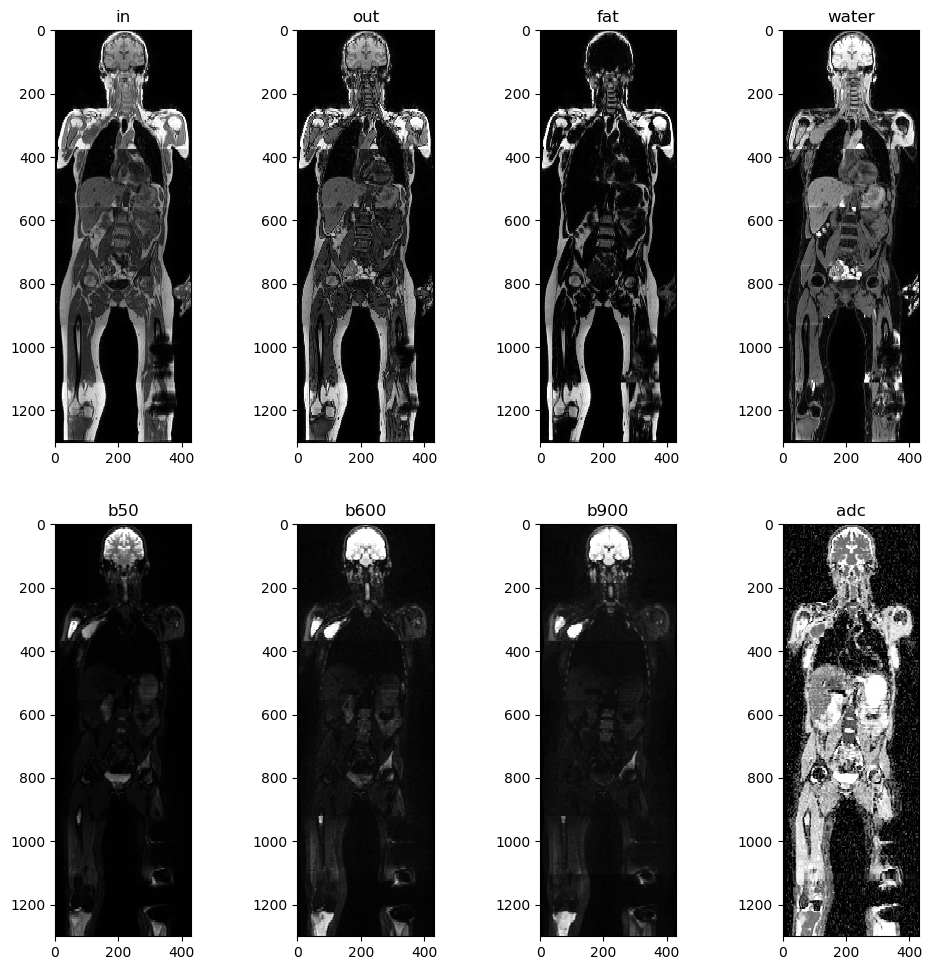

In [13]:
myshow2(imgs2, series_descriptions)

In [14]:
def write_sitk_image_volumes(imgs, readers, series_descriptons, series_numbers):
    print('--- Writing DICOM Series from SimpleITK ---')
    shutil.rmtree('temp/dicoms_new', ignore_errors=True)
    os.mkdir('temp/dicoms_new')
    for g, group in enumerate(imgs):
        for i, img in enumerate(group):
            reader = readers[g][i]
            series_description = series_descriptons[g][i]
            series_number = series_numbers[g][i]

            os.mkdir(os.path.join('temp/dicoms_new/',series_description))

            writer = sitk.ImageFileWriter()
            writer.KeepOriginalImageUIDOn()

            tags_to_copy = ["0010|0010", # Patient Name
                            "0010|0020", # Patient ID
                            "0010|0030", # Patient Birth Date
                            "0010|0040", # Patient Sex
                            "0010|4000", # Patient Comments
                            "0020|000D", # Study Instance UID, for machine consumption
                            "0020|0010", # Study ID, for human consumption
                            "0008|0020", # Study Date
                            "0008|0030", # Study Time
                            "0008|0050", # Accession Number
                            "0008|0060", # Modality
                            "0018|5100"  # Patient Position
                           ]

            modification_time = time.strftime("%H%M%S")
            modification_date = time.strftime("%Y%m%d")

            direction = img.GetDirection()
            slice_thickness = str(img.GetSpacing()[2])

            series_tag_values = [(k, reader.GetMetaData(0,k)) for k in tags_to_copy if reader.HasMetaDataKey(0,k)] + \
                         [("0008|0031",modification_time), # Series Time
                          ("0008|0021",modification_date), # Series Date
                          ("0020|0037", '\\'.join(map(str, (direction[0], direction[3], direction[6],# Image Orientation (Patient)
                                                            direction[1],direction[4],direction[7])))),
                          ("0008|103e", series_description), # Series Description
                          ('0020|0011', str(series_number)), # Series Number
                          ("0008|0008","DERIVED\\SECONDARY"), # Image Type
                          ("0020|000e", pydicom.uid.generate_uid(prefix='1.2.826.0.1.3680043.8.498.')), # Series Instance UID
                         ]
            for i in range(img.GetDepth()):
                image_slice = img[:,:,i]
                # Tags shared by the series.
                for tag, value in series_tag_values:
                    # print(tag)
                    image_slice.SetMetaData(tag, value)

                j = img.GetDepth() - i
                # Slice specific tags.
                image_slice.SetMetaData("0008|0012", time.strftime("%Y%m%d")) # Instance Creation Date
                image_slice.SetMetaData("0008|0013", time.strftime("%H%M%S")) # Instance Creation Time
                image_slice.SetMetaData("0020|0032", '\\'.join(map(str,img.TransformIndexToPhysicalPoint((0,0,i))))) # Image Position (Patient)
                image_slice.SetMetaData("0020|0013", str(j)) # Instance Number
                image_slice.SetMetaData("0018|0050", slice_thickness)
                image_slice.SetMetaData("0008|0018", pydicom.uid.generate_uid(prefix='1.2.826.0.1.3680043.8.498.'))

                # Write to the output directory and add the extension dcm, to force writing in DICOM format.

                writer.SetFileName(os.path.join('temp/dicoms_new',series_description, str(j)+'.dcm'))
                writer.Execute(image_slice)
            print('"' + series_description + '"', 'image volume saved')

In [16]:
write_sitk_image_volumes(imgs2, readers, series_descriptions, series_numbers)

--- Writing DICOM Series from SimpleITK ---
"in" image volume saved
"out" image volume saved
"fat" image volume saved
"water" image volume saved
"b50" image volume saved
"b600" image volume saved
"b900" image volume saved
"adc" image volume saved


In [115]:
for idx, d in df.groupby(['Sequence', 'Series']):
    if any(path == 'no path' for path in df.loc[idx, 'Path']):
        print(idx, 'Writing DICOM files')
        template_dcm_path = df.loc[idx][df.loc[idx, 'Path'] != 'no path'].iloc[0].Path
        template_dcm = pydicom.dcmread(template_dcm_path)
        new_dir = os.path.join(os.path.split(template_dcm_path)[0], 'new')
        shutil.rmtree(new_dir, ignore_errors=True)
        os.mkdir(new_dir)
        for i in range(1,len(df.loc[idx])+1):
            template_dcm.PixelData = df.loc[idx +(i,), 'PixelArray'].astype(np.int16).tobytes()
            try:
                ipp = ast.literal_eval(df.loc[idx +(i,), 'ImagePositionPatient'])
            except ValueError:
                ipp = df.loc[idx +(i,), 'ImagePositionPatient']
            template_dcm.ImagePositionPatient = ipp
            template_dcm.SliceLocation = df.loc[idx +(i,), 'SliceLocation']
            template_dcm.save_as(os.path.join(os.path.join(os.path.split(template_dcm_path)[0], 
                                                           'new'),str(i)+'.dcm'))

('diffusion', 'adc') Writing DICOM files
('diffusion', 'b50') Writing DICOM files
('diffusion', 'b600') Writing DICOM files
('diffusion', 'b900') Writing DICOM files
('dixon', 'fat') Writing DICOM files
('dixon', 'in') Writing DICOM files
('dixon', 'out') Writing DICOM files
('dixon', 'water') Writing DICOM files


In [118]:
df.loc[idx].dropna(subset=['PixelArray'], inplace=True)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [116]:
os.path.split(template_dcm_path)[0]

'temp/dicoms/water/20171012_190913_Aera/scans/56-fl3d_CAIPI_wb_tra_BH_20_set_go_W_COMPOSED/resources/DICOM/files'

In [111]:
df.loc[idx].tail()

,SeriesNumber,InstanceNumber,SliceLocation,SliceThickness,Rows,Columns,PixelSpacing,ImagePositionPatient,SeriesInstanceUID,SOPInstanceUID,Path,diff_down,diff_up,PixelArray,Contiguous
Slice,,,,,,,,,,,,,,,
258.0,8.0,258.0,-1087.905876,5.0,221.0,271.0,"[1.6044776439667, 1.6044776439667]","[-221.14737761021, -179.7265099287, -1087.9058...",1.3.12.2.1107.5.2.18.41171.2017101219522271914...,1.3.12.2.1107.5.2.18.41171.2017101219523191324...,no path,NaN,5.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",yes
259.0,8.0,259.0,-1092.905876,5.0,221.0,271.0,"[1.6044776439667, 1.6044776439667]","[-221.14737761021, -179.7265099287, -1092.9058...",1.3.12.2.1107.5.2.18.41171.2017101219522271914...,1.3.12.2.1107.5.2.18.41171.2017101219523191324...,no path,NaN,5.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",yes
260.0,8.0,260.0,-1097.905876,5.0,221.0,271.0,"[1.6044776439667, 1.6044776439667]","[-221.14737761021, -179.7265099287, -1097.9058...",1.3.12.2.1107.5.2.18.41171.2017101219522271914...,1.3.12.2.1107.5.2.18.41171.2017101219523191324...,no path,NaN,5.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",yes
261.0,NaN,261.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes
262.0,NaN,262.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes


In [96]:
template_dcm = pydicom.dcmread(template_dcm_path)

In [98]:
template_dcm.ImagePositionPatient

['-218.72945685272', '-163.67333027039', '7.094122081995']

In [88]:
os.path.split(template_dcm_path)[0]

'temp/dicoms/water/20171012_190913_Aera/scans/56-fl3d_CAIPI_wb_tra_BH_20_set_go_W_COMPOSED/resources/DICOM/files'

In [92]:
os.mkdir(os.path.join(os.path.split(template_dcm_path)[0], 'new'))

In [94]:
os.path.join(os.path.split(template_dcm_path)[0], 'new')

'temp/dicoms/water/20171012_190913_Aera/scans/56-fl3d_CAIPI_wb_tra_BH_20_set_go_W_COMPOSED/resources/DICOM/files/new'

In [91]:
str(i)+'.dcm'

'335.dcm'

In [84]:
template_dcm_path.split('/')[:3]

'tempdicomswater'

In [56]:
template_dcm = pydicom.dcmread(template_dcm_path)

In [71]:
template_dcm.PixelData = pa_new.astype(np.int16).tobytes()

In [72]:
template_dcm.save_as('test.dcm')

In [451]:
def load_sitk_slice(fn):
    reader = sitk.ImageFileReader()
    reader.SetFileName(fn)
    return reader.Execute()

In [627]:
df = pd.read_csv('df.csv')
df.drop('Slice', axis=1, inplace=True)  # for some reason df has a slice column, check in real code
df.set_index(['Sequence', 'Series', 'InstanceNumber'], drop=False, inplace=True)
df.drop(['Sequence', 'Series'], axis=1, inplace=True)  # Keep InstanceNumber column
df.rename_axis(index={'InstanceNumber': 'Slice'}, inplace=True)

st = 5

for idx, df_select in df.groupby(['Sequence', 'Series']):
    df.loc[idx, 'diff_down'] = df_select['SliceLocation'].diff().abs().round(2)
    # df.loc[idx][df.loc[idx,'diff_down'] == 0]['Path'].apply(lambda x: os.remove(x))  # remove duplicates
    print(idx, ' - Removed', len(df.loc[idx][df.loc[idx,'diff_down'] == 0]), 'duplicates')
df = df[df['diff_down'] != 0]  # drop duplicate rows

for idx, df_select in df.groupby(['Sequence', 'Series']):
    df.loc[idx, 'diff_up'] = df_select['SliceLocation'].diff(-1).abs().round(2)
    
#####################

for idx, d in df.groupby(['Sequence', 'Series']):
    if not all(diff == st for diff in df.loc[idx, 'diff_down']):
        print(idx, 'Loading DICOM slices as SimpleITK Volumes')
        df.loc[idx, 'ImageSlice'] = d.Path.apply(lambda x: load_sitk_slice(x))
        df.loc[idx, 'Interpolated'] = 'no'
        # df.loc[idx, 'Path'] = None ??  # Remove path -- also delete dcms?
        # first non-contiguous slice at beginnging of largest contiguous group
        start = d[d['diff_up'] != st].dropna()['InstanceNumber'].diff(-1).idxmin()[2]
        # first non-contiguous slice at end of largest contiguous group
        end = d[d['diff_down'] != st].dropna()['InstanceNumber'].diff().idxmax()[2]
        sl_ref_up = np.arange(df.loc[idx + (start+1,)].SliceLocation + st,
                             df.loc[idx, 'SliceLocation'].max(), st)  # new slice locations
        sl_ref_down = np.arange(df.loc[idx + (end-1,)].SliceLocation - st, 
                            df.loc[idx, 'SliceLocation'].min(), -st)  # new slice locations
        
        s_template = pd.DataFrame.copy(df.loc[idx+(1,)])
        s_template.Path = ''
        for i, sl in enumerate(np.concatenate((sl_ref_down, sl_ref_up))):
            s_new = pd.DataFrame.copy(s_template)
            s_new.SliceLocation = sl
            ipp_new = ast.literal_eval(s_new.ImagePositionPatient)
            ipp_new[2] = sl
            s_new.ImagePositionPatient = ipp_new
            s_new.ImageSlice.SetOrigin(ipp)
            s_new.Interpolated = 'yes'
            df.loc[idx+(i+len(d)+50,)] = s_new  
            # was having issues with slice overwriting so I just made the index gap big (50)

df = correct_slice_order(df)
                

('diffusion', 'adc')  - Removed 2 duplicates
('diffusion', 'b50')  - Removed 3 duplicates
('diffusion', 'b600')  - Removed 3 duplicates
('diffusion', 'b900')  - Removed 4 duplicates
('dixon', 'fat')  - Removed 0 duplicates
('dixon', 'in')  - Removed 0 duplicates
('dixon', 'out')  - Removed 0 duplicates
('dixon', 'water')  - Removed 0 duplicates
('diffusion', 'adc') Loading DICOM slices as SimpleITK Volumes
('diffusion', 'b50') Loading DICOM slices as SimpleITK Volumes
('diffusion', 'b600') Loading DICOM slices as SimpleITK Volumes
('diffusion', 'b900') Loading DICOM slices as SimpleITK Volumes
('dixon', 'fat') Loading DICOM slices as SimpleITK Volumes
('dixon', 'in') Loading DICOM slices as SimpleITK Volumes
('dixon', 'out') Loading DICOM slices as SimpleITK Volumes
('dixon', 'water') Loading DICOM slices as SimpleITK Volumes
-- Checking DICOM slice order --
Correcting ('diffusion', 'adc') slice order
Correcting ('diffusion', 'b50') slice order
Correcting ('diffusion', 'b600') slice or

This method of usimg sitk images is nicer, but so so much slower....

In [676]:
for idx, d in df.groupby(['Sequence', 'Series']):
    if not all(diff == st for diff in df.loc[idx, 'diff_down']):
        print(idx, 'Interpolating new slices')
        for i in range(1,len(df.loc[idx])):
            if df.loc[idx+(i,), 'Interpolated'] == 'yes':
                print(idx, i)
                i_prev = i-1
                i_next = i+1
                while df.loc[idx+(i_prev,), 'Interpolated'] == 'yes': i_prev -= 1
                while df.loc[idx+(i_next,), 'Interpolated'] == 'yes': i_next += 1
                # Slice Locations:
                sl_prev = df.loc[idx+(i_prev,), 'SliceLocation']
                sl = df.loc[idx+(i,), 'SliceLocation']
                sl_next = df.loc[idx+(i_next,), 'SliceLocation']
                # Pixel Arrays:
                pa_prev = sitk.GetArrayFromImage(df.loc[idx+(i_prev,), 'ImageSlice'])
                pa_next = sitk.GetArrayFromImage(df.loc[idx+(i_next,), 'ImageSlice'])
                
                x1 = abs(sl-sl_prev)
                x2 = abs(sl_next-sl)
                r1 = (x1/(x1+x2))
                r2 = (x2/(x1+x2))
                pa_new = r1*pa_prev + r2*pa_next
                
                image = df.loc[idx+(i,), 'ImageSlice']
                new_image = sitk.GetImageFromArray(pa_new)
                new_image.SetDirection(image.GetDirection())
                new_image.SetSpacing(image.GetSpacing())
                new_image.SetOrigin(image.GetOrigin())
                df.loc[idx + (i,)].ImageSlice = new_image
                      

('diffusion', 'adc') Interpolating new slices
('diffusion', 'adc') 2


//anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


('diffusion', 'adc') 4
('diffusion', 'adc') 6
('diffusion', 'adc') 8
('diffusion', 'adc') 10
('diffusion', 'adc') 12
('diffusion', 'adc') 14
('diffusion', 'adc') 16
('diffusion', 'adc') 18
('diffusion', 'adc') 20
('diffusion', 'adc') 22
('diffusion', 'adc') 24
('diffusion', 'adc') 26
('diffusion', 'adc') 28
('diffusion', 'adc') 30
('diffusion', 'adc') 32
('diffusion', 'adc') 34
('diffusion', 'adc') 36
('diffusion', 'adc') 38
('diffusion', 'adc') 40
('diffusion', 'adc') 42
('diffusion', 'adc') 44
('diffusion', 'adc') 46
('diffusion', 'adc') 48
('diffusion', 'adc') 50
('diffusion', 'adc') 52
('diffusion', 'adc') 54
('diffusion', 'adc') 56
('diffusion', 'adc') 58
('diffusion', 'adc') 60
('diffusion', 'adc') 62
('diffusion', 'adc') 64
('diffusion', 'adc') 66
('diffusion', 'adc') 68
('diffusion', 'adc') 70
('diffusion', 'adc') 72
('diffusion', 'adc') 74
('diffusion', 'adc') 260
('diffusion', 'adc') 261
('diffusion', 'adc') 262
('diffusion', 'adc') 264
('diffusion', 'adc') 266
('diffusion', 

('dixon', 'fat') 48
('dixon', 'fat') 50
('dixon', 'fat') 52
('dixon', 'fat') 54
('dixon', 'fat') 56
('dixon', 'fat') 58
('dixon', 'fat') 60
('dixon', 'fat') 62
('dixon', 'fat') 64
('dixon', 'fat') 66
('dixon', 'fat') 68
('dixon', 'fat') 70
('dixon', 'fat') 72
('dixon', 'fat') 74
('dixon', 'fat') 76
('dixon', 'fat') 261
('dixon', 'fat') 263
('dixon', 'fat') 265
('dixon', 'fat') 267
('dixon', 'fat') 269
('dixon', 'fat') 271
('dixon', 'fat') 273
('dixon', 'fat') 275
('dixon', 'fat') 277
('dixon', 'fat') 279
('dixon', 'fat') 281
('dixon', 'fat') 283
('dixon', 'fat') 285
('dixon', 'fat') 287
('dixon', 'fat') 289
('dixon', 'fat') 291
('dixon', 'fat') 293
('dixon', 'fat') 295
('dixon', 'fat') 297
('dixon', 'fat') 299
('dixon', 'fat') 301
('dixon', 'fat') 303
('dixon', 'fat') 305
('dixon', 'fat') 307
('dixon', 'fat') 309
('dixon', 'fat') 311
('dixon', 'fat') 313
('dixon', 'fat') 315
('dixon', 'fat') 317
('dixon', 'fat') 319
('dixon', 'fat') 321
('dixon', 'fat') 323
('dixon', 'fat') 325
('dixon

In [ ]:

            
            # Pixel Arrays
#                     pa = s.PixelArray
#                     pa_next = s_next.PixelArray
#                     # pa_new = np.zeros(s_new.PixelArray.shape)  # initialise new pixel array
#                     pa_new = ((st - (sl_new-sl))/st)*pa + ((st - (sl_next-sl_new))/st)*pa_next
#                     #print(((st - (sl_new-sl))/st), ((st - (sl_next-sl_new))/st))
#                     s_new.PixelArray = pa_new
        
            
        

#         for sl in sl_ref_down:
#             print('-------------',sl)
# #             print(df.iloc[(df.loc[idx,'SliceLocation']-sl).abs().argmax()]['SliceLocation'])
# #             print(df.iloc[(sl-df.loc[idx,'SliceLocation']).abs().argmin()]['SliceLocation'])
#             print(df.iloc[(df.loc[idx,'SliceLocation']-sl).abs().argsort()[:2]]['SliceLocation'])
            
            
            # almost but it depends how big the gap is, doesn't get values on either side
#             print(df.iloc[(df.loc[idx,'SliceLocation']-sl).abs().argsort()[:2]]['SliceLocation'])
#         for sl_i, i in enumerate(range(end ,len(d)+1)):
#             if df.loc[idx+(i,), 'SliceLocation'] != sl_ref_down[sl_i]:
#                 df.loc[idx+(i,), 'remove'] = 1 
#                 s_prev = df.loc[idx + (i-1,)]
#                 s = df.loc[idx + (i,)]  # copy row
#                 s_next = df.loc[idx + (i+1,)]
#                 if df.loc[idx+(i,),'diff_down'] < st:
#                     print('WE MADE IT')
#                     s_new = s  # not a proper copy, just another pointer
#                     # Slice Locations:
#                     sl_prev = s_prev.SliceLocation
#                     sl = s.SliceLocation  # get current slice location
#                     sl_next = s_next.SliceLocation
#                     sl_new = s_prev.SliceLocation + st
#                     s_new.SliceLocation = sl_new
#                     # ipp:
#                     ipp_new = ast.literal_eval(s.ImagePositionPatient)
#                     ipp_new[2] = ipp_new[2] + st  # only works for integer iops
#                     s_new.ImagePositionPatient = ipp_new
#                     # Pixel Arrays
#                     pa = s.PixelArray
#                     pa_next = s_next.PixelArray
#                     # pa_new = np.zeros(s_new.PixelArray.shape)  # initialise new pixel array
#                     pa_new = ((st - (sl_new-sl))/st)*pa + ((st - (sl_next-sl_new))/st)*pa_next
#                     #print(((st - (sl_new-sl))/st), ((st - (sl_next-sl_new))/st))
#                     s_new.PixelArray = pa_new
#                     df.loc[idx+(i+len(d),)] = s_new
#                 elif d['diff_down'].iloc[i] > 5:
#                     pass
#             elif d['diff_down'].iloc[i] == st:
#                 continue
#             else:
#                 print('something went wrong... slices not in right order?')
                
#         for i in range(start,0,-1):
#             if d['diff_up'].iloc[i] != st:
#                 print('yeee up')

In [111]:
type(df.loc[idx+(334,)].PixelArray)

NoneType

In [18]:
new.Rows = 800

In [20]:
new

Slice                                                                   1
SeriesNumber                                                            4
InstanceNumber                                                          1
SliceLocation                                                      201.57
SliceThickness                                                          5
Rows                                                                  800
Columns                                                               512
PixelSpacing                                             [0.8398, 0.8398]
ImagePositionPatient    [-218.72945685272, -163.67333027039, 201.56977...
SeriesInstanceUID       1.3.12.2.1107.5.2.18.41171.2017101219573215554...
SOPInstanceUID          1.3.12.2.1107.5.2.18.41171.2017101219573649164...
Path                                                                 None
diff_down                                                             NaN
diff_up                               

things that need to change:
slice = i + len
instance number = i + len
slice location = new one
ipp[2] = slice location
path = None
pixel array = new one

(not sure what to do with UIDs not, maybe just leave them blank?)

In [167]:
# remember df.loc[idx] = df_select
for idx, df_select in df.groupby(['Sequence', 'Series']):
    if not all(d == st for d in df.loc[idx, diff]):
        middle = int(len(df.loc[idx])/2)  # find middle of series
        defects = df.loc[idx][df.loc[idx,'diff'] != st*-1].index  # list of indices of non slice width spaces
        start = min(defects, key=lambda x:abs(x-middle)) # closest defect to middle
        if (start - middle) > 0:  # if the start is past the middle
            for i in range(start-1,len(df.loc[idx])+1):  # work downwards (increasing insantce/decreasing slice position)
                print(i)
        else:  # if the start is before the middle or the same
            for i in range(start,0,-1):
                print(i)
        

39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [219]:
idx

('dixon', 'water')

In [236]:
i = 1
idx + (i,)

('dixon', 'water', 1)

In [215]:
a = df.loc[('diffusion','adc',1)]

In [216]:
a['SliceLocation'] = 202

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Slice                                                                   1
SeriesNumber                                                            8
InstanceNumber                                                          1
SliceLocation                                                         202
SliceThickness                                                          5
Rows                                                                  221
Columns                                                               271
PixelSpacing                           [1.6044776439667, 1.6044776439667]
ImagePositionPatient    [-221.14737761021, -179.7265099287, 201.569778...
SeriesInstanceUID       1.3.12.2.1107.5.2.18.41171.2017101219522271914...
SOPInstanceUID          1.3.12.2.1107.5.2.18.41171.2017101219523191324...
Path                    temp/dicoms/adc/20171012_190913_Aera/scans/26-...
PixelArray              [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
diff                                  

In [217]:
df2.loc[('diffusion', 'adc',263)] = a

In [218]:
df2.loc[('diffusion', 'adc',263)]

Slice                                                                   1
SeriesNumber                                                            8
InstanceNumber                                                          1
SliceLocation                                                         202
SliceThickness                                                          5
Rows                                                                  221
Columns                                                               271
PixelSpacing                           [1.6044776439667, 1.6044776439667]
ImagePositionPatient    [-221.14737761021, -179.7265099287, 201.569778...
SeriesInstanceUID       1.3.12.2.1107.5.2.18.41171.2017101219522271914...
SOPInstanceUID          1.3.12.2.1107.5.2.18.41171.2017101219523191324...
Path                    temp/dicoms/adc/20171012_190913_Aera/scans/26-...
Name: (diffusion, adc, 263), dtype: object

In [174]:
for idx, df_select in df.groupby(['Sequence', 'Series']):
    if not all(d == st for d in df.loc[idx, 'diff']):
        for i in range(2 ,len(df.loc[idx])):
            if df.loc[idx, 'diff'].iloc[i] != st*-1:
                print(df.loc[idx, 'diff'].iloc[i])
            

-4.48
-19.52
-4.48
-14.52
-4.48
-19.52
-4.48
-4.52
-0.48
-4.52
-0.48
-4.52
-9.48
-9.52
-9.48
-9.52
-9.48
-9.52
-9.48
-9.52


In [ ]:
for idx, df_select in df.groupby(['Sequence', 'Series']):
    if not all(d == st for d in df.loc[idx, 'diff']):
        for i in range(2 ,len(df.loc[idx])):
            if df.loc[idx, 'diff'].iloc[i] != st*-1:
                s_prev = df.loc[idx + (i-1,)]
                s = df.loc[idx + (i,)]  # copy row
                s_next = df.loc[idx + (i+1,)]
            elif df.loc[idx, 'diff'].iloc[i] == st*-1:
                continue
            else:
                print('something went wrong... slices not in right order?')

 calculate which 2 non -5 diff is closet to the middle and then iterate backwards and forward from that respectively
 
 how about this: append the new slices on the end of the dataframe, then reorder them all at the end based on slice location and delete the ones that don't fit on the same uniform grid? you know when you have got to the end of the slices to process as you will hit NA on the diff value. 
 
 giving up on starting form the middle and just going to start from the top..... 
 giving up giving up, I have found a way! a way to find the indicies of the largest contiguous group

difference between df.loc and df_select is that the index of

In [507]:
d.index

MultiIndex(levels=[['diffusion', 'dixon'], ['adc', 'b50', 'b600', 'b900', 'fat', 'in', 'out', 'water'], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201

In [518]:
d.loc[idx].index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            252, 253, 254, 255, 256, 257, 258, 259, 260, 261],
           dtype='int64', name='Slice', length=259)

In [508]:
df.loc[idx].index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            252, 253, 254, 255, 256, 257, 258, 259, 260, 261],
           dtype='int64', name='Slice', length=259)

In [516]:
len(df.loc[idx])

259

In [519]:
idx

('diffusion', 'adc')

In [514]:
d.iloc[1]

Slice                                                                   2
SeriesNumber                                                            8
InstanceNumber                                                          2
SliceLocation                                                      196.57
SliceThickness                                                          5
Rows                                                                  221
Columns                                                               271
PixelSpacing                           [1.6044776439667, 1.6044776439667]
ImagePositionPatient    [-221.14737761021, -179.7265099287, 196.569778...
SeriesInstanceUID       1.3.12.2.1107.5.2.18.41171.2017101219522271914...
SOPInstanceUID          1.3.12.2.1107.5.2.18.41171.2017101219523190804...
Path                    temp/dicoms/adc/20171012_190913_Aera/scans/26-...
diff_down                                                               5
diff_up                               

In [513]:
df.loc[idx + (1,)]

Slice                                                                   1
SeriesNumber                                                            8
InstanceNumber                                                          1
SliceLocation                                                      201.57
SliceThickness                                                          5
Rows                                                                  221
Columns                                                               271
PixelSpacing                           [1.6044776439667, 1.6044776439667]
ImagePositionPatient    [-221.14737761021, -179.7265099287, 201.569778...
SeriesInstanceUID       1.3.12.2.1107.5.2.18.41171.2017101219522271914...
SOPInstanceUID          1.3.12.2.1107.5.2.18.41171.2017101219523191324...
Path                    temp/dicoms/adc/20171012_190913_Aera/scans/26-...
diff_down                                                             NaN
diff_up                               

In [ ]:
df = pd.read_csv('df.csv')
df.set_index(['Sequence', 'Series', 'InstanceNumber'], drop=False, inplace=True)
df.drop(['Sequence', 'Series'], axis=1, inplace=True)  # Keep InstanceNumber column
df.rename_axis(index={'InstanceNumber': 'Slice'}, inplace=True)
df.head()

for idx, df_select in df.groupby(['Sequence', 'Series']):
    df.loc[idx, 'diff_down'] = df_select['SliceLocation'].diff().abs().round(2)
    # df.loc[idx][df.loc[idx,'diff_down'] == 0]['Path'].apply(lambda x: os.remove(x))  # remove duplicates
    print(idx, ' - Removed', len(df.loc[idx][df.loc[idx,'diff_down'] == 0]), 'duplicates')
df = df[df['diff_down'] != 0]  # drop duplicate rows

for idx, df_select in df.groupby(['Sequence', 'Series']):
    df.loc[idx, 'diff_up'] = df_select['SliceLocation'].diff(-1).abs().round(2)
    
#####################

for idx, d in df.groupby(['Sequence', 'Series']):
    if not all(diff == st for diff in df.loc[idx, 'diff_down']):
        ####df.loc[idx, 'PixelArray'] = d.Path.apply(lambda x: pydicom.dcmread(x).pixel_array)
        pass
    while not all(diff == st for diff in df.loc[idx, 'diff_down']):
        df.loc[idx].sort_values(by='SliceLocation', ascending=False, inplace=True)
        start = d[d['diff_up'] != st].dropna()['InstanceNumber'].diff(-1).idxmin()[2]  # first non-contiguous slice at beginnging of largest contiguous group
        end = d[d['diff_down'] != st].dropna()['InstanceNumber'].diff().idxmax()[2]  # first non-contiguous slice at end of largest contiguous group
        
        
        # working down from largest group:
        for i in range(end ,len(d)):  # little bit confused what to do with last slice........
            if df.loc[idx+(i,),'diff_down'] != st:
                print('yeee down')
                df.loc[idx+(i,), 'remove'] = 1 
                s_prev = df.loc[idx + (i-1,)]
                s = df.loc[idx + (i,)]  # copy row
                s_next = df.loc[idx + (i+1,)]
                if df.loc[idx+(i,),'diff_down'] < st:
                    print('WE MADE IT')
                    s_new = s
                    # Slice Locations:
                    sl_prev = s_prev.SliceLocation
                    sl = s.SliceLocation  # get current slice location
                    sl_next = s_next.SliceLocation
                    sl_new = s_prev.SliceLocation + st
                    s_new.SliceLocation = sl_new
                    # ipp:
                    ipp_new = ast.literal_eval(s.ImagePositionPatient)
                    ipp_new[2] = ipp_new[2] + st  # only works for integer iops
                    s_new.ImagePositionPatient = ipp_new
                    # Pixel Arrays
                    pa = s.PixelArray
                    pa_next = s_next.PixelArray
                    # pa_new = np.zeros(s_new.PixelArray.shape)  # initialise new pixel array
                    pa_new = ((st - (sl_new-sl))/st)*pa + ((st - (sl_next-sl_new))/st)*pa_next
                    #print(((st - (sl_new-sl))/st), ((st - (sl_next-sl_new))/st))
                    s_new.PixelArray = pa_new
                    df.loc[idx+(i+len(d),)] = s_new
                elif d['diff_down'].iloc[i] > 5:
                    pass
            elif d['diff_down'].iloc[i] == st:
                continue
            else:
                print('something went wrong... slices not in right order?')
                
        for i in range(start,0,-1):
            if d['diff_up'].iloc[i] != st:
                print('yeee up')
                

In [3]:
import SimpleITK as sitk

In [4]:
writer = sitk.ImageFileWriter

In [ ]:
writer.